# Introduction to Machine Learning, Assignment 1. Fall 2020.
Lev Svalov,  DS-02

## 1. Linear/Polynomial Regression


In [283]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [284]:
# Creating the data:

rng = np.random.RandomState(1)
x = 10 * rng.rand(100)
y = np.sin(x) + 0.1 * rng.randn(100)
x = np.expand_dims(x,1)
x_test = np.linspace(0, 10, 100)
y_test = np.sin(x_test) + 0.1 * rng.randn(100)
x_test = np.expand_dims(x_test,1)

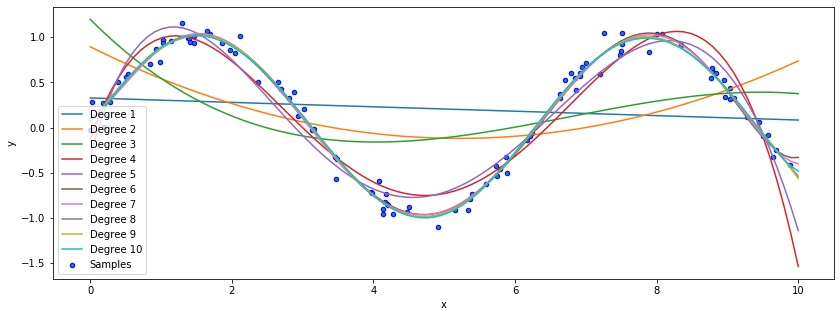

In [285]:
# Linear and Polynomial regressions

degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(14, 5))
MSEs = []
STDs = []
min_mse = float('inf')
best_degree = -1
for i in range(len(degrees)):
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(x, y)
    y_pred = pipeline.predict(x_test)
    scores = cross_val_score(pipeline, x, y,scoring="neg_mean_squared_error", cv=10)
    mse = mean_squared_error(y_test,y_pred)
    if mse < min_mse:
        min_mse = mse
        best_degree = degrees[i]
    std = np.std(scores)
    label = "Degree " + str(degrees[i])
    plt.plot(x_test, y_pred, label=label)
    MSEs.append(mse)
    STDs.append(std)

df = pd.DataFrame({'Degree': degrees,'MSE':MSEs, 'std':STDs})
df.set_index('Degree', inplace=True)
plt.scatter(x, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")
plt.show()

In [286]:
df

,MSE,std
Degree,,
1,0.445031,0.105181
2,0.364622,0.071997
3,0.340571,0.086485
4,0.058013,0.027489
5,0.042861,0.017651
6,0.010463,0.005500
7,0.009994,0.005280
8,0.010378,0.006101
9,0.010454,0.006276


As we can see from the table, the smallest MSE (the best model) has model with degree:

In [287]:
print(best_degree)

7


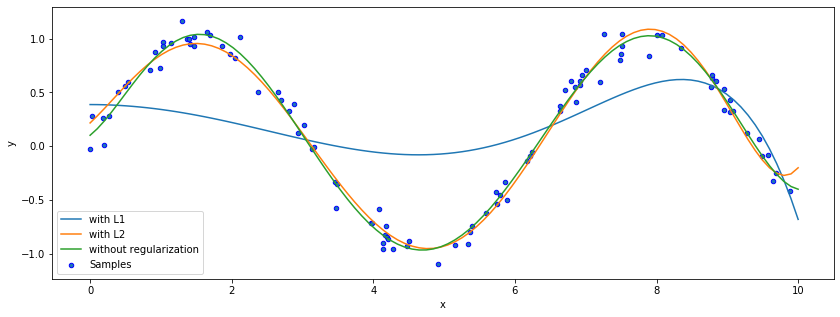

In [288]:
# Regularization

plt.figure(figsize=(14, 5))
polynomial_features = PolynomialFeatures(degree=best_degree, include_bias=False)

# Lasso L1-regularization
lasso = Lasso(tol=0.4)
pipeline_L1 = Pipeline([("polynomial_features", polynomial_features),
                     ("lasso_regression", lasso)])
pipeline_L1.fit(x, y)
y_pred_l1 = pipeline_L1.predict(x_test)
label = "with L1"
plt.plot(x_test, y_pred_l1, label=label)

# Ridge L2-regularization
ridge = Ridge(tol=0.4)
pipeline_L2 = Pipeline([("polynomial_features", polynomial_features),
                     ("ridge_regression", ridge)])
pipeline_L2.fit(x, y)
y_pred_l2 = pipeline_L2.predict(x_test)
label = "with L2"
plt.plot(x_test, y_pred_l2, label=label)

# without regularization
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                    ("linear_regression", linear_regression)])
pipeline.fit(x, y)
y_pred = pipeline.predict(x_test)
label = "without regularization"
plt.plot(x_test, y_pred, label=label)

scores_L1 = cross_val_score(pipeline_L1, x, y,scoring="neg_mean_squared_error", cv=10)
std_L1 = np.std(scores_L1)
mse_L1 = mean_squared_error(y_test,y_pred_l1)

scores_L2 = cross_val_score(pipeline_L2, x, y,scoring="neg_mean_squared_error", cv=10)
std_L2 = np.std(scores_L2)
mse_L2 = mean_squared_error(y_test,y_pred_l2)

scores = cross_val_score(pipeline, x, y,scoring="neg_mean_squared_error", cv=10)
mse = mean_squared_error(y_test,y_pred)
std = np.std(scores)

df = pd.DataFrame({'Model': ["with L1", "with L2", "without regularization"],'MSE':[mse_L1, mse_L2, mse], 'std':[std_L1, std_L2, std]})


plt.scatter(x, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")
plt.show()

In [289]:
df

,Model,MSE,std
0,with L1,0.249936,0.083080
1,with L2,0.014458,0.009991
2,without regularization,0.009994,0.005280


As we can see, adding the L1 and L2 regularization did not give us better performance,
the error has become bigger for both cases.

##  2. Logistic Regression

In [290]:
df = pd.read_csv("/Users/levsvalov/code_workspace/Fall2020/ML/Assignment1/banking.csv")
df.head(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999.0,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999.0,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6.0,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999.0,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3.0,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [291]:
#Data preprocessing

# split data
x = df.loc[:, df.columns != 'y']
y = df['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [292]:
# imputing

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(x_train)
x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

In [293]:
# one-hot-encode

def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_name))
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

#categorical columns
categories = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome' ]

encoder = OneHotEncoder(sparse=False, drop='first')
encoder.fit(x_train[categories])
x_train = ohe_new_features(x_train, categories, encoder)
x_test = ohe_new_features(x_test, categories, encoder)

In [294]:
x_train

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,33,182,2,999,0,-0.1,93.2,-42,4.076,5195.8,...,0,1,0,0,0,1,0,0,1,0
1,41,378,3,999,0,1.1,93.994,-36.4,4.856,5191,...,1,0,0,0,0,0,1,0,1,0
2,59,216,2,999,0,-1.8,92.893,-46.2,1.291,5099.1,...,1,0,0,0,0,0,1,0,1,0
3,23,633,1,999,0,1.1,93.994,-36.4,4.857,5191,...,1,0,0,0,1,0,0,0,1,0
4,36,114,3,999,0,1.4,93.444,-36.1,4.966,5228.1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,47,167,1,999,0,-1.8,93.075,-47.1,1.445,5099.1,...,0,0,0,0,0,0,0,1,1,0
32946,57,212,1,999,0,1.1,93.994,-36.4,4.857,5191,...,1,0,0,0,1,0,0,0,1,0
32947,38,350,2,999,2,-1.8,92.843,-50,1.687,5099.1,...,0,0,0,0,0,0,1,0,0,0
32948,39,155,3,999,0,1.1,93.994,-36.4,4.857,5191,...,1,0,0,0,1,0,0,0,1,0


In [295]:
# feature scaling

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [296]:
#Model creation

model = LogisticRegression()
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
    },
    {'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs'],
    }
]

clf = GridSearchCV(model,param_grid=param_grid,verbose=True, cv=5, n_jobs=-1)
best_clf = clf.fit(x_train, y_train)
print("The best set of hyper-parameters for the model: ")
print(best_clf.best_estimator_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
The best set of hyper-parameters for the model: 
LogisticRegression(C=1438.44988828766, penalty='l1', solver='liblinear')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


In [297]:
y_test_pred = clf.predict(x_test)

print("Metrics:")
print('accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Metrics:
accuracy = 0.9100509832483612
precision = 0.6815286624203821
recall = 0.44169246646026833
